In [1]:
# %%
# date: 2022-11-24
# author: Yin Zi
# This code is used to convert the maps generated by the wfc algorithm to directed graph, in this version it is only compatible with the modified fastwfc I wrapped with pybind11.
# The original version of the fast-wfc code is from here: https://github.com/math-fehr/fast-wfc, thanks to the author for his great work.

import numpy as np
import networkx as nx
from typing import List
import copy
from itertools import combinations

"""
Convert the format of input tiles_id, this is important for building graphs because we want each node to have its own node id.
Args:
       tiles_id: The format of input tiles_id is something like: [(0, 1), (0, 2), ...], where the first element is the index of the tile, and the second element means rotation(0 for 0 degree, and 1 for 90 degree, 2 for 180 degree, 3 for 270 degree).
                That means there are 4 different tiles with the same index, but different rotation, so we have to unfold them to make sure each identical tile has its unqiue.
       size: The size of the grid, default is 81(9x9).
Returns:
        new_data:
        The ouput newdata will be something like: [0, 1, 2, 3, ..., N], where N is the number of all oriented tiles, for example, 0 is for the original (0,0), and 1 is for (0,1).
"""
def tiles2data(tiles_id, size=81):
    data = np.array(tiles_id)
    # Make the tile index start from 1 instead of 0.
    # This is due to some historical reasons, once for compatibility with my colleague's code, even it is not used at all anymore.
    # Humans always have differences, even on such smallest things.
    data[:, 0]+=1   # Make the tile index start from 1 instead of 0.
    # reshape the tile data to size x 2
    ndata=data.reshape(size,2)
    # the total tiles number is 26
    sum_tiles = 26
    # the total rotations is 4
    sum_rotations = 4
    # some boring initialization
    x = np.arange(1, sum_tiles+1)
    y = np.arange(sum_rotations)
    tiledict = {}
    count = 0
    # Create a mapping dictionary
    for i in x:
        for j in y:
            tiledict[str([i,j])] = count
            count+=1
    # Using the mapping dictionary to convert the input tiles_id to new_data
    newdata = []
    for i in ndata.tolist():
        newdata.append(tiledict[str(i)])
    return newdata


"""
Rules for setting whether a neighbor is connected or not.
Using rule combination to get the connectity dict.
"""
def get_connectity_dict(out_height_dict=False):

    # Some initial values used to calculate node index of the tile
    num_cubes = 6
    num_corners = 15
    num_ramps = 5
    rotations_count = 4
    # Build the tile node set(for subsequent set operations) and list(to collect and obtain)
    range1 = rotations_count*num_cubes
    cube_list = list(range(range1))
    cube_set = set(cube_list)
    range2 = range1 + rotations_count * num_corners
    corner_list = list(range(range1, range2))
    corner_set = set(corner_list)
    range3 = range2 + rotations_count * num_ramps
    num_all = range3
    ramp_list = list(range(range2, range3))
    ramp_set = set(ramp_list)
    all_list = list(range(num_all))
    """
    Our map has 6 height layers in total, where the corresponding tiles are assigned to the corresponding layers using a dictionary table.
    Some boundary values are set just in case, so as to save the boundary judgment logic.
    To make it easier to understand, here are a table of the tile index and their easy-to-understand names:
    TIP1: Height and color are actually one-to-one correspondence, for example, gray is 1, blue is 2, ...
    TIP2: The corners are mamed in order of color from left to right, for example, corner_blue_gray means the left part of the tile is blue, and the right part is gray.
    TIP3: Since the corner is a mix of two height bricks, I only assign the height based on the higher color while making it accessible to both height bricks(direction limited).
          This will lead to an abnormal path like lowcube->corner->highcube, which should be filtered out later.

    | ID          | Name                 | Height |
    | ----------- | -------------------- | ------ |
    | 0,1,2,3     | gray_cube            | 1      |
    | 4,5,6,7     | blue_cube            | 2      |
    | 8,9,10,11   | yellow_cube          | 3      |
    | 12,13,14,15 | orange_cube          | 4      |
    | 16,17,18,19 | red_cube             | 5      |
    | 20,21,22,23 | white_cube           | 6      |
    | 24,25,26,27 | corner_blue_gray     | 2      |
    | 28,29,30,31 | corner_yellow_blue   | 3      |
    | 32,33,34,35 | corner_orange_yellow | 4      |
    | 36,37,38,39 | corner_red_orange    | 5      |
    | 40,41,42,43 | corner_white_red     | 6      |
    | 44,45,46,47 | corner_yellow_gray   | 3      |
    | 48,49,50,51 | corner_orange_blue   | 4      |
    | 52,53,54,55 | corner_red_yellow    | 5      |
    | 56,57,58,59 | corner_white_orange  | 6      |
    | 60,61,62,63 | corner_orange_gray   | 4      |
    | 64,65,66,67 | corner_red_blue      | 5      |
    | 68,69,70,71 | corner_white_yellow  | 6      |
    | 72,73,74,75 | corner_red_gray      | 5      |
    | 76,77,78,79 | corner_white_blue    | 6      |
    | 80,81,82,83 | corner_white_gray    | 6      |
    | 84,85,86,87 | ramp_blue            | 2      |
    | 88,89,90,91 | ramp_yellow          | 3      |
    | 92,93,94,95 | ramp_orange          | 4      |
    | 96,97,98,99 | ramp_red             | 5      |
    | 100,101,102,103 | ramp_white          | 6      |
    """
    height_tile_dict = {
        0: set(),
        1: set(all_list[:4]),
        2: set(all_list[4:8]+all_list[24:28]+all_list[84:88]),
        3: set(all_list[8:12]+all_list[28:32]+all_list[44:48]+all_list[88:92]),
        4: set(all_list[12:16]+all_list[32:36]+all_list[48:52]+all_list[60:64]+all_list[92:96]),
        5: set(all_list[16:20]+all_list[36:40]+all_list[52:56]+all_list[64:68]+all_list[72:76]+all_list[96:100]),
        6: set(all_list[20:24]+all_list[40:44]+all_list[56:60]+all_list[68:72]+all_list[76:80]+all_list[80:84]+all_list[100:104]),
        7: set(),
    }
    # 0: 0 degree, 1: 90 degree, 2: 180 degree, 3: 270 degree
    rotation_dict = {
        0: set(range(0,num_all,4)),
        1: set(range(1,num_all,4)),
        2: set(range(2,num_all,4)),
        3: set(range(3,num_all,4)),
    }
    direction_list = ["up", "down", "left", "right"]
    # Rule 1: Blocks of the same height can be connected
    # Collect blocks of the same height in a dict
    same_height_dict = {}
    for i in range(num_all):
        same_height_dict[i] = set()
        for value in height_tile_dict.values():
            # If tile i is in current height layer, then add all tiles in this layer to the same_height_dict
            if i in value:
                # Deprecated code: does not contain itself
                # same_height_dict[i] = value - set([i])
                same_height_dict[i] = value
    # Rule2 is for blocks of lower height than the current one
    # Collect blocks of lower height in a dict
    lower_height_dict = {}
    for i in range(num_all):
        lower_height_dict[i] = set()
        for key, value in height_tile_dict.items():
            # If tile i is in current layer, then add all tiles in the lower layer to the dict
            if i in value:
                # Traverse from the bottom_level to the current_level - 1
                for j in range(key):
                    # Set operation: merge
                    lower_height_dict[i] |= height_tile_dict[j]
    # Rule 3: Direction-specific corners allow passage of low-level blocks.
    # Collect proper corners: correct height and direction
    """
              up
           lef █ right
              down
    example: proper_corner_dict = {
         0: {
             "up": [],
             "down": [],
             "left": [],
             "right": [],
         },
        1: ....}
    # when tile_height == corner_height - 1, corenrs with proper direction are allowed to pass
    # example: ▉ means low cube, ◢ means corner with direction
    #       ◢ | ◣        
    #     ◢ ▉ | ▉ ◣
    # -----------------
    #     ◥ ▉ | ▉ ◤      
    #       ◥ | ◤
    # 
    """
    proper_corner_rotation = {
       "up":[1, 2],
       "down": [0, 3],
       "left": [0, 1],
       "right": [2, 3],
    }

    # when tile_height >= corner_height, one-way traffic, high to low only
    proper_corner_dict = {}
    for i in range(num_all):
        proper_corner_dict[i] = {}
        for key, value in height_tile_dict.items():
            if i in value:
                tile_height = key
                proper_height_corner_set = set()
                # for tile_height >= corner_height, all corners are proper
                for j in range(tile_height+1):
                    proper_height_corner_set |= (height_tile_dict[j] & corner_set)
                # for tile_height == corner_height - 1, corners with limited direction are proper
                corner_height = tile_height + 1
                corners_in_corner_height = height_tile_dict[corner_height] & corner_set
                for direction in direction_list:
                    proper_corner_dict[i][direction] = set()
                    # choose a corner with correct height and correct rotation for spefic direction
                    rotations = proper_corner_rotation[direction]
                    for rot in rotations:
                        # choose a corner with correct height and correct rotation for spefic direction
                        direction_limited_high_corners = corners_in_corner_height & rotation_dict[rot]
                        # merge to proper_corner_dict
                        proper_corner_dict[i][direction] |= direction_limited_high_corners
                    # merge height rule
                    proper_corner_dict[i][direction] |= proper_height_corner_set 
    # Rule 4: proper ramp: correct height and angle
    """
    example: T is ramp, ▉ is higher cube
    proper ramp:
                ▉
                T
    improper ramp:
                ▉
                -|
    -----------------
    example: proper_ramp_dict = {
         0: {
             "up": [],
             "down": [],
             "left": [],
             "right": [],
         },
        1: ....}
    """
    # when tile_height == ramp_height - 1, ramp's direction should be limited
    proper_ramp_rotation_for_up = {
        "up":[0],
        "down": [2],
        "left": [3],
        "right": [1],
    }

    proper_ramp_dict = {}
    for i in range(num_all):
        proper_ramp_dict[i] = {}
        for key, value in height_tile_dict.items():
            if i in value:
                tile_height = key
                proper_height_ramp_set = set()
                 # for tile_height >= ramp_height, all ramps are proper
                for j in range(tile_height+1):
                    proper_height_ramp_set = proper_height_ramp_set | (height_tile_dict[j] & ramp_set)
                # for tile_height == ramp_height - 1, ramp's direction should be limited
                ramp_height = tile_height + 1
                # choose ramps with correct height
                ramps_in_ramp_height = height_tile_dict[ramp_height] & ramp_set
                for direction in direction_list:
                    rotations = proper_ramp_rotation_for_up[direction]
                    proper_ramp_dict[i][direction] = set()
                    # choose a ramp with correct height and correct rotation for spefic direction
                    for rot in rotations:
                        # choose a ramp with correct height and correct rotation for spefic direction
                        direction_limited_high_ramps =  ramps_in_ramp_height & rotation_dict[rot]
                        # merge to proper_ramp_dict
                        proper_ramp_dict[i][direction] |= direction_limited_high_ramps
                    # merge height rule
                    proper_ramp_dict[i][direction] |= proper_height_ramp_set
    # Optional, because wfc's rules never generate such maps
    # when ramp's neb is a ramp, some direction should be limited
    ramp_exclude_dict = {}
    for n in [ramp_list[0], ramp_list[4], ramp_list[8], ramp_list[12], ramp_list[16]]:
        ramp_exclude_dict.update({
                n: {
                    'up':  set([n, n+1, n+2, n+3]),
                    'down':  set([n, n+1, n+2, n+3]),
                    'left':  set([n+1]),
                    'right': set([n+3]),
                },
                n+1:{
                    'up':  set([n+2]),
                    'down': set([n]),
                    'left':  set([n, n+1, n+2, n+3]),
                    'right': set([n, n+1, n+2, n+3]),
                },
                n+2:{
                    'up':  set([n, n+1, n+2, n+3]),
                    'down': set([n, n+1, n+2, n+3]),
                    'left':  set([n+1]),
                    'right': set([n+3]),
                },
                n+3:{
                    'up':  set([n+2]),
                    'down': set([n]),
                    'left':  set([n, n+1, n+2, n+3]),
                    'right': set([n, n+1, n+2, n+3]),
                }

        })

    # rule combination
    con_dict = {}
    for i in range(num_all):
        con_dict[i] = {}
        for direction in direction_list:
            con_dict[i][direction] = same_height_dict[i] | lower_height_dict[i] | proper_corner_dict[i][direction] | proper_ramp_dict[i][direction]
            # apply ramp exlcude rule
            if i in ramp_exclude_dict.keys():
                if direction in ramp_exclude_dict[i].keys():
                    con_dict[i][direction] = con_dict[i][direction] - set(ramp_exclude_dict[i][direction])
    if out_height_dict:
        return con_dict, height_tile_dict
    else:
        return con_dict

"""
Collect neighbor information into the dictionary
"""
def get_neighbour(size=81):
    witdh = int(np.sqrt(size))
    height = int(np.sqrt(size))
    np_map = np.arange(size).reshape(witdh, height)
    neighbour_dict = {}
    for i in range(height):
        for j in range(witdh):
            neighbour_dict[np_map[i][j]] = {}
            if i > 0:
                # print(f"up pos={i, j} i>0: get={i-1,j} {np_map[i-1][j]}")
                neighbour_dict[np_map[i][j]]["up"] = np_map[i-1][j]
            if i < height - 1:
                # print(f"down pos={i,j} i<8: get={i+1,j} {np_map[i+1][j]}")
                neighbour_dict[np_map[i][j]]["down"] = np_map[i+1][j]
            if j > 0:
                # print(f"left pos={i,j} j>0:  get={i,j-1}{np_map[i][j-1]}")
                neighbour_dict[np_map[i][j]]["left"] = np_map[i][j-1]
            if j < witdh - 1:
                # print(f"right pos={i,j} j<8:  get={i,j+1} {np_map[i][j+1]}")
                neighbour_dict[np_map[i][j]]["right"] = np_map[i][j+1]
    return neighbour_dict

# Just to bind index and value together
class TileClass:
    def __init__(self, index, value):
        self.index = index
        self.value = value

    def __repr__(self):
        return f"TileClass({self.index}, {self.value})"
    
    def __str__(self):
        return f"TileClass({self.index}, {self.value})"

# Get connectivity rules
connectity_dict = get_connectity_dict()
# Convert the rules we defined into the adjacency needed by NetworkX
def map2adjacency(map_in: List, size=81):
    # map shape(81,1)
    # Get neighbor information
    neighbour_dict = get_neighbour(size=size)
    adjacency = {i: [] for i in range(size)}
    for i, tile in enumerate(map_in):
        neb = neighbour_dict[i]
        con = connectity_dict[tile]
        for key in neb.keys():
            valid_neb_tile = map_in[neb[key]]
            if valid_neb_tile in con[key]:
                adjacency[i].append(TileClass(neb[key],valid_neb_tile))
    return adjacency

def map2digraph(map_in: List, size=81):
    adjacency = map2adjacency(map_in, size=size)
    DG = nx.DiGraph()
    for i,node in enumerate(adjacency.keys()):
        DG.add_node(node, tile=map_in[i])
    for key, value in adjacency.items():
        for v in value:
            DG.add_edge(key, v.index)
    return DG

"""
Calculate all shortest paths after filtering out the wrong paths caused by corners(i.e.: low -> corner -> high, this is something only ramps can do.
"""
def get_all_pair_shortest_path(DG, return_dict=False):
    # Some initial values used to calculate node index of the tile
    num_cubes = 6
    num_corners = 15
    num_ramps = 5
    rotations_count = 4 
    num_all = (num_cubes + num_corners + num_ramps) * rotations_count
    all_list = list(np.arange(num_all))
    cube_list = all_list[0:24]
    corner_list = all_list[24:84]
    height_tile_dict = get_connectity_dict(out_height_dict=True)[1]
    tileid2nodeid = {}
    for i in range(len(DG.nodes)):
        tileid2nodeid[DG.nodes[i]['tile']] = []
    for i in range(len(DG.nodes)):
        node = DG.nodes[i]
        tileid2nodeid[node['tile']].append(i)
    # set exclude rule
    all_exclude_path_list = []
    for cube_id in cube_list:
        for key, value in height_tile_dict.items():
            # find current cube height
            if cube_id in value:
                # travel higher height
                for i in range(key+1, 7):
                    corners_at_this_height = set(corner_list) & height_tile_dict[i]
                    cubes_at_this_height = set(cube_list) & height_tile_dict[i]
                    for i_corner in corners_at_this_height:
                        for i_cube in cubes_at_this_height:
                            # only keep rule for tiles that is in currunt map
                            if cube_id in tileid2nodeid.keys() and i_corner in tileid2nodeid.keys() and i_cube in tileid2nodeid.keys():
                                # print(f"cube_id={cube_id} i_corner={i_corner} i_cube={i_cube}")
                                for low_cube in tileid2nodeid[cube_id]:
                                    for corner in tileid2nodeid[i_corner]:
                                        for high_cube in tileid2nodeid[i_cube]:
                                            # all_exclude_path_list.append([tileid2nodeid[cube_id], tileid2nodeid[i_corner], tileid2nodeid[i_cube]])
                                            all_exclude_path_list.append([low_cube, corner, high_cube])
                            else:
                                continue
    # helper function to check if a small list is in a big list
    def contains(small, big):
        for i in range(len(big)-len(small)+1):
            for j in range(len(small)):
                if big[i+j] != small[j]:
                    break
            else:
                # return i, i+len(small)
                return True
        return False
    all_shortest_paths = []
    all_shortest_paths_dict = {}
    # Iterate over each node as the starting node
    for n in DG:
        # First find all shortest paths normally
        path = nx.single_source_shortest_path(DG, n)
        # Then start checking if there is an incorrect path among these shortest paths, and if so, find a new path without the incorrect rule to replace it
        # The wrong route means low cube -> corner -> high cube
        path_dict = {}
        for key in path.keys():
            shortest_paths = list(path[key])
            if(len(shortest_paths) < 3):
                all_shortest_paths.append(shortest_paths)
                path_dict[key] = shortest_paths
                continue
            for exlcude in all_exclude_path_list:
                if(contains(exlcude, shortest_paths)):
                    # print(f"exclude path: {path[key]} from {n} to {key}, exclude rule:{exlcude}. Trying to change another path")
                    all_simple_paths = nx.all_simple_paths(DG, n, key, cutoff=len(shortest_paths)+4)
                    all_simple_paths_list = list(all_simple_paths)
                    min = 100
                    min_path = []
                    for simple_paths in all_simple_paths_list:
                        if len(simple_paths) < min:
                            accepted = True
                            for iter_exlcude in all_exclude_path_list:
                                if contains(iter_exlcude, simple_paths):
                                    accepted = False
                            if accepted:
                                min = len(simple_paths)
                                min_path = simple_paths
                    shortest_paths = min_path
                    # DG.remove_edge(n, key)
                    break
            all_shortest_paths.append(shortest_paths)
            path_dict[key] = shortest_paths
        all_shortest_paths_dict[n] = path_dict
    if return_dict:
        return all_shortest_paths, all_shortest_paths_dict
    else:
        return all_shortest_paths



In [2]:
from WFCUnity3DEnv_fastwfc_nodepair import WFCUnity3DEnv
file_name = "./wfc_unity2_render/mac_build/1209_mac_built.app/Contents/MacOS/tilemap_render"
# unity_env = WFCUnity3DEnv(file_name=file_name)
wfc_size = 9
return_all = False
# wfc_unity = WFCUnity3DEnv(wfc_size=wfc_size, host="127.0.0.1", return_all=return_all)
wfc_unity = WFCUnity3DEnv(wfc_size=wfc_size, file_name=file_name, return_all=return_all)
# wfc_unity_old = WFCUnity3DEnv_old(wfc_size=wfc_size, host="127.0.0.1")
# 摆放位置

/Users/yinzi/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Trying to connect to 0.0.0.0:20926


[[63, 7]]


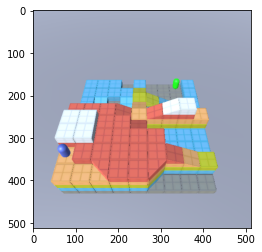

In [3]:
import fastwfc
import matplotlib.pyplot as plt
import os
from utils import json_to_tileid
# wfc = fastwfc.XLandWFC("samples_99.xml")
# ids,_ = wfc.generate(out_img=False)
# base_wave = wfc.wave_from_id(ids)
ids = json_to_tileid("corner_error.json")
DG = map2digraph(tiles2data(ids))
wfc_unity.set_wave(ids)
img = wfc_unity.render_in_unity()
plt.imshow(img)
plt.pause(0.01)

# os.system(f"kill -9 $(ps aux | grep '{file_name}' | awk '{{print $2}}')")

In [4]:
all_shortest_path,all_shortest_path_dict = get_all_pair_shortest_path(DG, return_dict=True)

In [5]:
all_shortest_path

[[0],
 [0, 9],
 [0, 1],
 [0, 9, 18],
 [0, 9, 10],
 [0, 1, 2],
 [0, 9, 18, 27],
 [0, 9, 18, 19],
 [0, 9, 10, 11],
 [0, 1, 2, 3],
 [0, 9, 18, 27, 28],
 [0, 9, 18, 19, 20],
 [0, 9, 10, 11, 12],
 [0, 9, 18, 27, 28, 29],
 [0, 9, 10, 11, 12, 21],
 [0, 9, 18, 27, 28, 29, 30],
 [1],
 [1, 10],
 [1, 0],
 [1, 2],
 [1, 10, 19],
 [1, 10, 9],
 [1, 10, 11],
 [1, 2, 3],
 [1, 10, 19, 28],
 [1, 10, 19, 18],
 [1, 10, 19, 20],
 [1, 10, 11, 12],
 [1, 10, 19, 28, 29],
 [1, 10, 19, 18, 27],
 [1, 10, 11, 12, 21],
 [1, 10, 19, 28, 29, 30],
 [2],
 [2, 11],
 [2, 1],
 [2, 3],
 [2, 11, 20],
 [2, 11, 10],
 [2, 11, 12],
 [2, 1, 0],
 [2, 11, 20, 29],
 [2, 11, 10, 19],
 [2, 11, 10, 9],
 [2, 11, 12, 21],
 [2, 11, 20, 29, 28],
 [2, 11, 20, 29, 30],
 [2, 11, 10, 19, 18],
 [2, 11, 10, 19, 18, 27],
 [3],
 [4],
 [4, 13],
 [4, 3],
 [4, 5],
 [4, 13, 22],
 [4, 13, 12],
 [4, 13, 14],
 [4, 5, 6],
 [4, 13, 22, 31],
 [4, 13, 22, 21],
 [4, 13, 22, 23],
 [4, 13, 12, 11],
 [4, 13, 14, 15],
 [4, 5, 6, 7],
 [4, 13, 22, 31, 40],
 [4, 13

In [6]:
# All longest shortest path node pairs
max_shortest_path_length = 0
for i,shortest_path in enumerate(all_shortest_path):
    if len(shortest_path) > max_shortest_path_length:
        max_shortest_path_length = len(shortest_path)
# collect all path with max length
all_max_shortest_path = []
for i,shortest_path in enumerate(all_shortest_path):
    if len(shortest_path) == max_shortest_path_length:
        all_max_shortest_path.append(shortest_path)

In [7]:
all_max_shortest_path

[[54, 45, 36, 37, 38, 39, 40, 31, 22, 13, 4, 5, 6, 7],
 [64, 65, 56, 47, 38, 39, 40, 31, 22, 13, 4, 5, 6, 7],
 [69, 68, 59, 58, 49, 40, 31, 22, 13, 12, 11, 2, 1, 0],
 [74, 65, 56, 47, 38, 39, 40, 31, 22, 13, 4, 5, 6, 7],
 [77, 68, 59, 58, 49, 40, 31, 22, 13, 12, 11, 2, 1, 0]]

In [13]:
all_exclude_path_list

NameError: name 'all_exclude_path_list' is not defined

In [41]:
wfc_unity.reset()
# img = unity_env.render_in_unity()
# plt.imshow(img)
# plt.pause(0.01)

array([[[128, 158, 197],
        [128, 158, 197],
        [128, 158, 197],
        ...,
        [139, 171, 213],
        [139, 171, 213],
        [139, 171, 214]],

       [[131, 161, 199],
        [131, 161, 199],
        [131, 161, 199],
        ...,
        [142, 174, 216],
        [142, 174, 216],
        [142, 175, 217]],

       [[133, 163, 202],
        [133, 163, 202],
        [133, 163, 202],
        ...,
        [145, 177, 219],
        [145, 178, 220],
        [145, 178, 220]],

       ...,

       [[193,  91,  85],
        [190,  89,  84],
        [190,  89,  83],
        ...,
        [154, 161, 182],
        [154, 161, 182],
        [154, 161, 183]],

       [[255, 198, 125],
        [255, 198, 125],
        [255, 198, 125],
        ...,
        [154, 161, 182],
        [154, 161, 182],
        [154, 161, 182]],

       [[213, 162,  99],
        [213, 162,  99],
        [211, 161,  97],
        ...,
        [153, 161, 182],
        [154, 161, 182],
        [154, 161, 182]]

In [9]:
from utils import tileid_to_json

In [10]:
import json
json_data = tileid_to_json(ids, "corner_error.json")


{'data': [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  22,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  21,
  0,
  0,
  0,
  21,
  0,
  2,
  0,
  22,
  1,
  21,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  23,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  24,
  1,
  3,
  0,
  24,
  3,
  25,
  3,
  5,
  0,
  3,
  0,
  5,
  0,
  5,
  0,
  4,
  0,
  4,
  0,
  24,
  2,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  5,
  0,
  5,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  3,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  4,
  0,
  24,
  1,
  23,
  1,
  2,
  0,
  3,
  0,
  3,
  0,
  9,
  2,
  4,
  0,
  4,
  0,
  18,
  3,
  0,
  0,
  0,
  0,
  0,
  0]}

In [11]:
wfc_unity._NODE_PAIRS

[[63, 7]]